In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

import os
import numpy as np
import matplotlib as plt

from PIL import Image

In [2]:
# print(torch.rand(10000,10000).cuda()) # check
# torch.cuda.current_device()
# torch.cuda.device_count()

In [3]:
# Data Normalization - channel=（channel-mean）/std
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Data augmetation
train_data = datasets.ImageFolder(os.getcwd(),
                             transforms.Compose([
                                 transforms.Scale(256),
                                 transforms.RandomSizedCrop(227),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(), # 转换成tensor
                                 normalize])
                                 )

/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.


In [4]:
# batch size
batch_s = 128
n_iters = 3000
num_classes = len(train_data.classes)
num_epochs = n_iters / (len(train_data) / batch_s)
num_epochs = int(num_epochs)

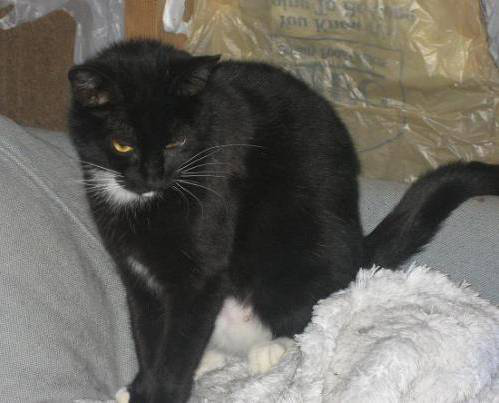

In [18]:
# load initial picture
im = Image.open(train_data.imgs[2000][0])
#plt.imshow(im)
im

In [23]:
# load batch data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_s,
    shuffle=True)

In [24]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x


class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            #nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2), ＃搭配size=224 https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(-1, 6*6*256)
        x = self.fc3(self.fc2(self.fc1(x)))
        return x

model = AlexNet()
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
iters = 0
for epoch in range(2):
    for i, (images, labels) in enumerate(train_loader):
        # convert tensor to Variable
        images = Variable(images)
        labels = Variable(labels)

        # clear gradients w.r.t parameters
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = loss_func(outputs, labels)

        # get gradient w.r.t parameters
        loss.backward()

        # update parameters
        optimizer.step()

        iters += 1

        if iters % 5 == 0:
            print("Iteration: {}. Loss: {}.".format(iters, loss.data[0]))